Create an environment and agent...
Environment and agent successfully created
Load the trained model...
Start testing the model for 1 epochs...
Epoch 1: Score = 2000.0


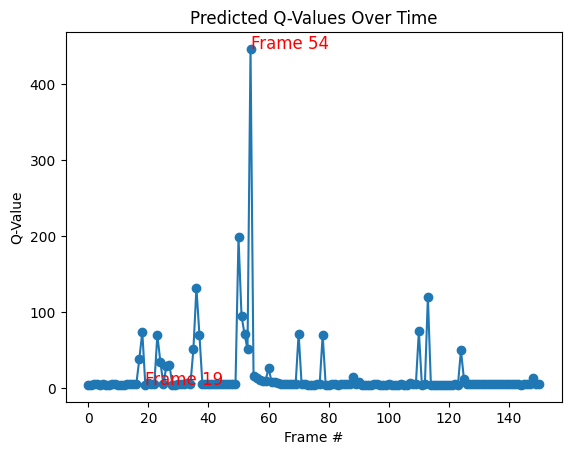

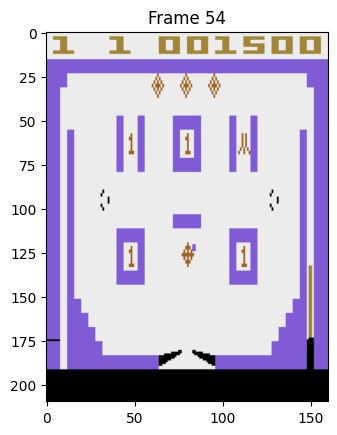

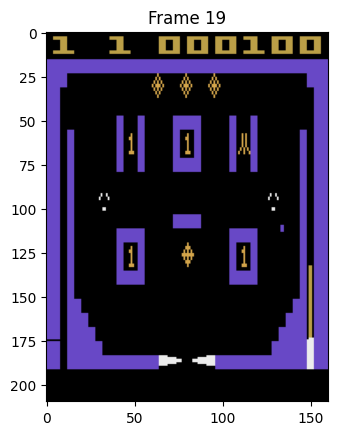

Testing complete
Exiting...


In [3]:
import gymnasium as gym
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import count
from typing import List, Optional, Tuple
from agent import DQNAgent
from dqn import DQN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_q_values(q_values: List[float], frames: List[np.ndarray], significant_frames: List[int]) -> None:
    plt.figure()
    plt.plot(q_values, marker='o')
    for idx in significant_frames:
        plt.text(idx, q_values[idx], f'Frame {idx}', fontsize=12, color='red')
    plt.xlabel('Frame #')
    plt.ylabel('Q-Value')
    plt.title('Predicted Q-Values Over Time')
    plt.show()

    for idx in significant_frames:
        plt.figure()
        plt.imshow(frames[idx])
        plt.title(f'Frame {idx}')
        plt.show()

def models(num_epochs: int, start_frame: int, end_frame: int) -> None:
    files = os.listdir()
    if "dqn_model.pth" not in files:
        print("Model not found. Please train the model first via 'python train.py'")
        print("Exiting...")
        return
    else:
        print("Create an environment and agent...")
        env = gym.make("ALE/VideoPinball-v5", render_mode="rgb_array")
        agent = DQNAgent(env=env, batch_size=128, gamma=0.99, eps_start=0.9, eps_end=0.05, eps_decay=1000, tau=0.0005, lr=1e-4, memory_size=50000, path=".")
        print("Environment and agent successfully created")
        
        # Load the trained model
        print("Load the trained model...")
        agent.policy_net.load_state_dict(torch.load("dqn_model.pth", map_location=torch.device('cpu')))
        agent.policy_net.eval()
        
        print(f"Start testing the model for {num_epochs} epochs...")
        for epoch in range(num_epochs):
            state, _ = env.reset()
            state = agent.preprocess_frame(frame=state)
            state = np.stack([state] * 4, axis=0)  # Stack 4 frames for the initial state
            state = torch.from_numpy(state).unsqueeze(dim=0).to(device=device, dtype=torch.float32)

            total_reward = 0.0
            q_values = []
            frames = []

            for t in count():
                if t < start_frame:
                    action = agent.select_action(state=state)
                    observation, reward, terminated, truncated, _ = env.step(action=action.item())
                    reward = torch.tensor(data=[reward], device=device)
                    total_reward += reward.item()
                    done = terminated or truncated

                    if not done:
                        next_frame = agent.preprocess_frame(frame=observation)
                        next_state = np.append(state.cpu().numpy()[0, 1:], np.expand_dims(next_frame, axis=0), axis=0)
                        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).to(device=device, dtype=torch.float32)
                    else:
                        next_state = None

                    state = next_state

                    if done:
                        break

                    continue

                if t > end_frame:
                    break

                action = agent.select_action(state=state)
                with torch.no_grad():
                    q_value = agent.policy_net(state).max(dim=1)[0].item()
                q_values.append(q_value)

                observation, reward, terminated, truncated, _ = env.step(action=action.item())
                frames.append(env.render())

                reward = torch.tensor(data=[reward], device=device)
                total_reward += reward.item()
                done = terminated or truncated

                if not done:
                    next_frame = agent.preprocess_frame(frame=observation)
                    next_state = np.append(state.cpu().numpy()[0, 1:], np.expand_dims(next_frame, axis=0), axis=0)
                    next_state = torch.from_numpy(next_state).unsqueeze(dim=0).to(device=device, dtype=torch.float32)
                else:
                    next_state = None

                state = next_state

                if done:
                    break

            print(f"Epoch {epoch + 1}: Score = {total_reward}")

            # Identify significant frames (highest and lowest Q-values within the range)
            max_q_index = np.argmax(q_values)
            min_q_index = np.argmin(q_values)
            significant_frames = [max_q_index, min_q_index]
            plot_q_values(q_values, frames, significant_frames)

        print("Testing complete")
        print("Exiting...")

if __name__ == "__main__":
    models(num_epochs=1, start_frame=50, end_frame=200)